# M2608.001300 Machine Learning <br> Assignment #3-2 support vector machine, RBF kernel

Copyright (C) Data Science and Artificial Intelligence Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jeonghee Jo, April 2018

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **student_id** as input argument. <br>
This will produce a zipped file called *[student_id].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; student_id)

## Load dataset

In [1]:
import pickle
import random
import time

from __future__ import print_function
import numpy as np
from numpy import exp, linalg
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
f = open("train_images.pickle", 'rb')
train_images = pickle.load(f)
f.close()

f2 = open("train_labels.pickle", 'rb')
train_labels = pickle.load(f2)
f2.close()

g = open("test_images.pickle", 'rb')
test_images = pickle.load(g)
g.close()

g2 = open("test_labels.pickle", 'rb')
test_labels = pickle.load(g2)
g2.close()

In [3]:
print("train images shape: ", train_images.shape)
print("train labels shape: ", train_labels.shape)
print("test images shape: ", test_images.shape)
print("test labels shape: ", test_labels.shape)

train images shape:  (10000, 28, 28)
train labels shape:  (10000,)
test images shape:  (5000, 28, 28)
test labels shape:  (5000,)


In [4]:
num_training = train_images.shape[0]
image_size = train_images.shape[1]

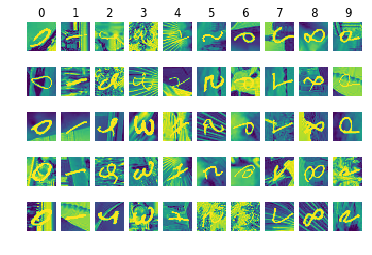

In [5]:
classes = list(range(10))

num_classes = 10
sample_per_class = 5
np.random.seed(0)

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx)
        plt.imshow(train_images[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

In [6]:
train_images = np.reshape(train_images, (np.array(train_images).shape[0], -1))
test_images = np.reshape(test_images, (np.array(test_images).shape[0], -1))

print("Training data shape: ", train_images.shape)
print("Test data shape: ", test_images.shape)

Training data shape:  (10000, 784)
Test data shape:  (5000, 784)


In [7]:
train_temp = np.zeros(train_images.shape)
test_temp = np.zeros(test_images.shape)

In [8]:
#ADDED PREPROCESSING STAGE
#threshld function

for i in range(train_images.shape[0]):
    train_temp[i] = (train_images[i]+0.027).astype(int)
        
for i in range(test_images.shape[0]):
    test_temp[i] = (test_images[i]+0.027).astype(int)

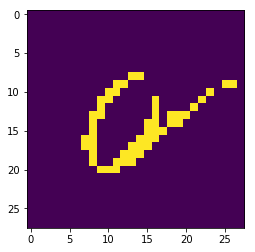

In [9]:
plt.imshow(train_temp[0].reshape((28,28)))

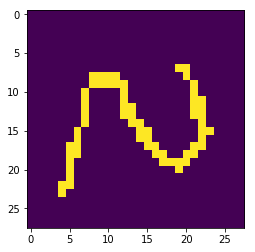

In [10]:
plt.imshow(test_temp[0].reshape((28,28)).astype('uint8'))

In [11]:
train_images = train_temp
test_images = test_temp

In [12]:
np.random.seed(0)

[0.0129 0.0123 0.012  0.0106 0.0108 0.0113 0.0125 0.0117 0.0107 0.0098]


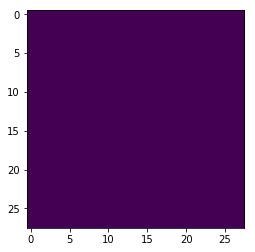

In [13]:
mean_image = np.mean(train_images, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28)).astype('uint8'))
plt.show()

In [14]:
train_images -= mean_image
test_images -= mean_image

In [15]:
train_images = np.hstack([train_images, np.ones((train_images.shape[0], 1))])
test_images = np.hstack([test_images, np.ones((test_images.shape[0], 1))])
train_labels_onehot = np.zeros((len(train_labels), 10))
train_labels_onehot[range(len(train_labels)), train_labels] += 1

print("train_images", train_images.shape)
print("train_labels", train_labels.shape)
print("test_images", test_images.shape)
print("test_labels", test_labels.shape)
print("train_labels_onehot", train_labels_onehot.shape)

train_images (10000, 785)
train_labels (10000,)
test_images (5000, 785)
test_labels (5000,)
train_labels_onehot (10000, 10)


In [16]:


class RBFSVM(object):
    
    def __init__(self):
        self.W = None
        self.loss_history = []
        self.num_train = None
        self.num_classes = None
        self.K = None
        self.train_data = None
        self.train_labels_onehot = None
        self.gamma = 1.0
        
    def get_kernel(self, X, y, gamma):
        self.num_train = X.shape[0]
        self.num_classes = y.shape[1]
        
        K = np.zeros((self.num_train, self.num_train, self.num_classes))
        
        for i in range(self.num_train):
            for j in range(self.num_train):
                
                temp = np.matmul((X[i]-X[j]), (X[i]-X[j]).T)
                K[i, j] = np.exp(-1.*gamma*temp)
           
        self.K = K
        return K
    
    
    def setK(self, K):
        self.K = K
        
        
    def train(self, X, y, gamma, num_iters, verbose=True):
        
        self.num_train = X.shape[0]
        self.num_classes = y.shape[1]
        self.train_data = X
        self.train_labels_onehot = y
        self.gamma = gamma
        
        alpha = np.zeros((self.num_train, self.num_classes))
        
        alpha_opt = None
        acc_opt = 0
        
        # Gram matrix
                
        for iteration in range(num_iters):
            
            print()
            print("iter", iteration)
            
            for i in range(self.num_train):
                s = np.zeros(self.num_classes) # sum of values
                v = np.zeros(self.num_classes) # value
                for j in range(self.num_train):
                    v = self.K[i][j] * y[j] * alpha[j]  # TO DO
                    s = s + v
                s = np.argmax(s)

                if s != np.argmax(y[i]):
                    alpha[i] = alpha[i] + y[i]
            
            #print error 
            
            test_labels_pred = self.predict(X, alpha)
            test_acc = np.mean(test_labels_pred == train_labels)
            
            test_labels_pred2 = self.predict(test_images, alpha)
            test_acc2 = np.mean(test_labels_pred2 == test_labels)
            
            print("training accuracy :", test_acc*100)
            print("test accuracy :", test_acc2*100)
            
            if acc_opt < test_acc2:
                acc_opt = test_acc2
                alpha_opt = alpha.copy()
            
        return alpha_opt, acc_opt
        
    def predict(self, X, alpha): ######## YOU CAN CAHANGE
        
        num_test = X.shape[0]
        
        pred = np.zeros((X.shape[0], self.num_classes))
        
        # TO DO
        #
        #
        for i in range(num_test):
            
            pred[i] = np.zeros(self.num_classes) # sum of values
            v = np.zeros(self.num_classes) # value
            
            for j in range(self.num_train):
                
                temp = np.matmul((self.train_data[j]-X[i]), (self.train_data[j]-X[i]).T)
                temp = np.exp(-1.*self.gamma*temp)
                v = temp * self.train_labels_onehot[j] * alpha[j]  # TO DO
                pred[i] = pred[i] + v
            
        
        y_pred = np.argmax(pred, axis=1)
        
        return y_pred

In [17]:
rbfsvm = RBFSVM()

In [18]:
stime = time.time()

opt_acc = 0
opt_alpha = None

K = None
gammas = [0.0475, 0.048]

for g in gammas:
    print()
    print('calculating kernel for gamma =', g)
    K = rbfsvm.get_kernel(train_images, train_labels_onehot, gamma=g)
    print('kernel matrix calculated, start  training iteration...')
    rbfsvm.setK(K)
    alpha, acc = rbfsvm.train(train_images, train_labels_onehot, gamma=0.05, num_iters=10)
    if acc>opt_acc:
        opt_acc = acc
        opt_alpha = alpha
    print('opt accuracy :', opt_acc)
#alpha = rbfsvm.train(train_images, train_labels_onehot, gamma=1.0, num_iters=10)

etime = time.time()


calculating kernel for gamma = 0.0475
kernel matrix calculated, start  training iteration...

iter 0
training accuracy : 94.58
test accuracy : 83.36

iter 1
training accuracy : 97.21
test accuracy : 84.26

iter 2
training accuracy : 98.7
test accuracy : 85.08

iter 3
training accuracy : 99.0
test accuracy : 85.18

iter 4
training accuracy : 99.2
test accuracy : 85.1

iter 5
training accuracy : 99.48
test accuracy : 85.2

iter 6
training accuracy : 99.48
test accuracy : 84.96000000000001

iter 7
training accuracy : 99.68
test accuracy : 84.82

iter 8
training accuracy : 99.52
test accuracy : 85.18

iter 9
training accuracy : 99.71
test accuracy : 84.84
opt accuracy : 0.852

calculating kernel for gamma = 0.048


MemoryError: 

In [43]:
print(etime-stime)

11988.814771652222


In [45]:
stime = time.time()
test_labels_pred = rbfsvm.predict(test_images,  alpha)
etime = time.time()

In [46]:
print(etime - stime)

326.08546471595764


In [48]:
test_acc = np.mean(test_labels_pred == test_labels)
print(test_acc*100)

85.7


In [ ]:

calculating kernel for gamma = 0.0455
kernel matrix calculated, start  training iteration...

iter 0
training accuracy : 94.14
test accuracy : 83.46000000000001

iter 1
training accuracy : 95.28999999999999
test accuracy : 82.3

iter 2
training accuracy : 96.85000000000001
test accuracy : 83.64

iter 3
training accuracy : 98.3
test accuracy : 83.98

iter 4
training accuracy : 98.81
test accuracy : 84.44

iter 5
training accuracy : 99.15
test accuracy : 85.22

iter 6
training accuracy : 98.81
test accuracy : 84.54

iter 7
training accuracy : 98.8
test accuracy : 84.56

iter 8
training accuracy : 99.35000000000001
test accuracy : 85.1

iter 9
training accuracy : 99.22999999999999
test accuracy : 85.04
opt accuracy : 0.8522